# マルチインプットマルチアウトプットモデル

## 前提情報

以下のファイルが下記パスにあること

1. ラベル情報ファイル (2022/2/22 時点)
    * ./20220222_sueki_label.csv
2. 須恵器データファイル(voxelファイル) (2022/04/20 時点)
    *  ./data/voxel/
3. 須恵器データファイル(画像ファイル) (2022/04/20 時点)
    * ./data/image/



In [5]:
# TensorFlow 2.9.2
!pip install -q --upgrade protobuf==3.19
!pip install -q --upgrade tensorflow==2.9.2

## GPU情報確認

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue May  2 09:23:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.216.04   Driver Version: 450.216.04   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-80GB      On   | 00000000:01:00.0 Off |                    0 |
| N/A   34C    P0    61W / 275W |      0MiB / 81252MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-SXM4-80GB      On   | 00000000:47:00.0 Off |                    0 |
| N/A   

In [4]:
# Create output dir 
import datetime
now = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9))) # 日本時刻

output_dir = './weight-ones_output_{}'.format(now.strftime('%Y%m%d%H%M%S'))

!mkdir $output_dir

### 必要パッケージのインポート

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB4

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, GlobalAveragePooling3D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import random

import os
import glob
import sys

### 3Dデータ読み込み

In [3]:
df_label = pd.read_csv('./data_sueki/20220222_sueki_label.csv',index_col=0)

In [4]:
df_label.head()

,身・蓋,列品番号,型式,年代（6世紀）,向き,データセット,class_type,class_age
0,futa,J-6564,Ⅱ－３,中葉,1,train,2,1
1,futa,J-6568,Ⅱ－３,中葉,1,train,2,1
2,futa,J-6569,Ⅱ－５,後葉,1,train,4,2
3,futa,J-6570,Ⅱ－４,後葉,1,valid,3,2
4,futa,J-6572,Ⅱ－３,中葉,1,valid,2,1


In [5]:
class_type = {0:'Ⅱ－１',1:'Ⅱ－２',2:'Ⅱ－３',3:'Ⅱ－４',4:'Ⅱ－５'}
class_age = {0:'前葉',1:'中葉',2:'後葉'}


def get_keys_from_value(d, val):
    return str([k for k, v in d.items() if v == val][0])

for i in range(len(df_label)):
    df_label.loc[i,'class_type'] = get_keys_from_value(class_type, df_label.iloc[i,2])
    df_label.loc[i,'class_age'] = get_keys_from_value(class_age, df_label.iloc[i,3])

df_label

,身・蓋,列品番号,型式,年代（6世紀）,向き,データセット,class_type,class_age
0,futa,J-6564,Ⅱ－３,中葉,1,train,2,1
1,futa,J-6568,Ⅱ－３,中葉,1,train,2,1
2,futa,J-6569,Ⅱ－５,後葉,1,train,4,2
3,futa,J-6570,Ⅱ－４,後葉,1,valid,3,2
4,futa,J-6572,Ⅱ－３,中葉,1,valid,2,1
...,...,...,...,...,...,...,...,...
103,mi,J-3650,Ⅱ－５,後葉,0,train,4,2
104,mi,J-11536,Ⅱ－５,後葉,0,train,4,2
105,mi,J-22896-19,Ⅱ－５,後葉,0,train,4,2
106,mi,J-22896-21,Ⅱ－５,後葉,0,train,4,2


## 学習（クラス分類）

### データ読み込み

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB4

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, GlobalAveragePooling3D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import random

import os
import glob
import sys

In [7]:
class_type = {0:'Ⅱ－１',1:'Ⅱ－２',2:'Ⅱ－３',3:'Ⅱ－４',4:'Ⅱ－５'}
class_age = {0:'前葉',1:'中葉',2:'後葉'}

num_class_type = len(class_type)
num_class_age = len(class_age)


MT_SIZE = 128
IM_WIDTH = IM_HEIGHT = 380

#EfficientNetB0 – (224, 224, 3)
#EfficientNetB1 – (240, 240, 3)
#EfficientNetB2 – (260, 260, 3)
#EfficientNetB3 – (300, 300, 3)
#EfficientNetB4 – (380, 380, 3)
#EfficientNetB5 – (456, 456, 3)
#EfficientNetB6 – (528, 528, 3)
#EfficientNetB7 – (600, 600, 3)

In [8]:
###### ファイル名から正解ラベルを取り出す関数
def parse_filepath(filepath):
    # ラベル(str)、ボクセルサイズ(int)、番号(int) を返す
    try:
        path, filename = os.path.split(filepath)  # 相対パスからファイル名を取り出す
        filename, ext = os.path.splitext(filename)  # 拡張子を除く
        mifuta, name, label_type, label_age, size, angle = filename.split("_")
        return mifuta, name, int(label_type), int(label_age), int(size), int(angle) 


    except Exception as e:  # いくつか欠損値があるので例外処理をしておく
        print(filepath)
        return None, None, None, None, None, None

voxels = []

DATA_DIR = './data_sueki/voxel_128'
files = glob.glob(os.path.join(DATA_DIR, "*.npy")) 
files.sort()

attributes = list(map(parse_filepath, files))  # 上で作成した関数にファイル名を一つずつ入力


In [9]:
df = pd.DataFrame(attributes)
df['voxel_path'] = files

df.columns = ['mifuta', 'name', 'label_type', 'label_age', 'voxel_size', 'angle', 'voxel_path']

images_top, images_side, images_bottom = [], [], []
dataset = []
for i in range(len(df)):
  
    images_top.append('./data_sueki/image/{}_{}_{}_{}_top_{:0=3}.png'.format(df.loc[i, 'mifuta'], df.loc[i, 'name'], df.loc[i, 'label_type'], df.loc[i, 'label_age'], df.loc[i, 'angle']))
    images_side.append('./data_sueki/image/{}_{}_{}_{}_side_{:0=3}.png'.format(df.loc[i, 'mifuta'], df.loc[i, 'name'], df.loc[i, 'label_type'], df.loc[i, 'label_age'], df.loc[i, 'angle']))
    images_bottom.append('./data_sueki/image/{}_{}_{}_{}_bottom_{:0=3}.png'.format(df.loc[i, 'mifuta'], df.loc[i, 'name'], df.loc[i, 'label_type'], df.loc[i, 'label_age'], df.loc[i, 'angle']))

    dataset.append('{}'.format(df_label[df_label['列品番号'] == df.loc[i, 'name']]['データセット'].iloc[-1]))


df['image_top_path'] = images_top
df['image_side_path'] = images_side
df['image_bottom_path'] = images_bottom
df['dataset'] = dataset

df.columns = ['mifuta', 'name', 'label_type', 'label_age', 'voxel_size', 'angle', 'voxel_path', 'image_top_path', 'image_side_path', 'image_bottom_path','dataset']







data_num = 12

train_idx =[]
valid_idx =[]
test_idx =[]

for i in range(len(df)):

    if df.loc[i,'dataset'] == 'train':
        train_idx.extend([i])
    elif df.loc[i,'dataset'] == 'valid':
        valid_idx.extend([i])
    elif df.loc[i,'dataset'] == 'test':
        test_idx.extend([i])

random.shuffle(train_idx)

df

,mifuta,name,label_type,label_age,voxel_size,angle,voxel_path,image_top_path,image_side_path,image_bottom_path,dataset
0,futa,J-11536,4,2,128,0,./data_sueki/voxel_128/futa_J-11536_4_2_128_00...,./data_sueki/image/futa_J-11536_4_2_top_000.png,./data_sueki/image/futa_J-11536_4_2_side_000.png,./data_sueki/image/futa_J-11536_4_2_bottom_000...,train
1,futa,J-11536,4,2,128,30,./data_sueki/voxel_128/futa_J-11536_4_2_128_03...,./data_sueki/image/futa_J-11536_4_2_top_030.png,./data_sueki/image/futa_J-11536_4_2_side_030.png,./data_sueki/image/futa_J-11536_4_2_bottom_030...,train
2,futa,J-11536,4,2,128,60,./data_sueki/voxel_128/futa_J-11536_4_2_128_06...,./data_sueki/image/futa_J-11536_4_2_top_060.png,./data_sueki/image/futa_J-11536_4_2_side_060.png,./data_sueki/image/futa_J-11536_4_2_bottom_060...,train
3,futa,J-11536,4,2,128,90,./data_sueki/voxel_128/futa_J-11536_4_2_128_09...,./data_sueki/image/futa_J-11536_4_2_top_090.png,./data_sueki/image/futa_J-11536_4_2_side_090.png,./data_sueki/image/futa_J-11536_4_2_bottom_090...,train
4,futa,J-11536,4,2,128,120,./data_sueki/voxel_128/futa_J-11536_4_2_128_12...,./data_sueki/image/futa_J-11536_4_2_top_120.png,./data_sueki/image/futa_J-11536_4_2_side_120.png,./data_sueki/image/futa_J-11536_4_2_bottom_120...,train
...,...,...,...,...,...,...,...,...,...,...,...
1291,mi,J-9830,4,2,128,210,./data_sueki/voxel_128/mi_J-9830_4_2_128_210.npy,./data_sueki/image/mi_J-9830_4_2_top_210.png,./data_sueki/image/mi_J-9830_4_2_side_210.png,./data_sueki/image/mi_J-9830_4_2_bottom_210.png,train
1292,mi,J-9830,4,2,128,240,./data_sueki/voxel_128/mi_J-9830_4_2_128_240.npy,./data_sueki/image/mi_J-9830_4_2_top_240.png,./data_sueki/image/mi_J-9830_4_2_side_240.png,./data_sueki/image/mi_J-9830_4_2_bottom_240.png,train
1293,mi,J-9830,4,2,128,270,./data_sueki/voxel_128/mi_J-9830_4_2_128_270.npy,./data_sueki/image/mi_J-9830_4_2_top_270.png,./data_sueki/image/mi_J-9830_4_2_side_270.png,./data_sueki/image/mi_J-9830_4_2_bottom_270.png,train
1294,mi,J-9830,4,2,128,300,./data_sueki/voxel_128/mi_J-9830_4_2_128_300.npy,./data_sueki/image/mi_J-9830_4_2_top_300.png,./data_sueki/image/mi_J-9830_4_2_side_300.png,./data_sueki/image/mi_J-9830_4_2_bottom_300.png,train


In [10]:
print(train_idx)
print(valid_idx)
print(test_idx)

[1288, 694, 1184, 424, 888, 123, 368, 829, 815, 487, 658, 248, 473, 109, 365, 430, 653, 669, 1112, 684, 683, 983, 1020, 933, 316, 14, 1247, 890, 681, 154, 367, 148, 610, 1137, 151, 611, 607, 774, 804, 118, 1287, 1241, 226, 323, 810, 911, 364, 141, 1186, 129, 807, 594, 320, 1031, 655, 635, 126, 1213, 379, 604, 1078, 4, 702, 1062, 495, 82, 778, 350, 493, 731, 659, 671, 313, 590, 627, 228, 480, 11, 568, 377, 239, 798, 1239, 470, 256, 722, 633, 975, 1129, 1176, 347, 1023, 500, 631, 707, 688, 1183, 1080, 1064, 1082, 42, 648, 900, 133, 341, 1240, 926, 1005, 696, 1246, 808, 243, 1090, 119, 245, 362, 626, 756, 46, 572, 113, 497, 705, 1187, 761, 896, 905, 77, 542, 666, 112, 1223, 767, 1030, 904, 793, 769, 1215, 998, 220, 137, 225, 996, 110, 114, 73, 704, 1115, 218, 575, 44, 728, 766, 573, 893, 336, 345, 721, 474, 837, 47, 19, 1028, 222, 918, 913, 252, 258, 232, 255, 602, 360, 492, 1237, 479, 762, 132, 108, 685, 1063, 809, 597, 547, 692, 420, 353, 374, 1024, 1188, 830, 431, 689, 1000, 792, 670, 

In [11]:
# データ拡張
# https://axa.biopapyrus.jp/deep-learning/sample/augmentation.html

import numpy as np
import skimage

def augmentation_rotation(img):
    r = np.random.rand(1)

    if r > 0.50:
        random_degree = random.uniform(0, 90)
        img = skimage.transform.rotate(img, random_degree, resize=True, cval=0)

    return img


def augmentation_flip(img, vertical=True, horizontal=True):

    if vertical:
        if np.random.rand(1) > 0.5:
            img = img[::-1, :, :] # 上下反転

    if horizontal:
        if np.random.rand(1) > 0.5:
            img = img[:, ::-1, :] # 左右反転

    return img

def augmentation_noise(img):
    r = np.random.rand(1)

    if r < 1/7:
        img = skimage.util.random_noise(img, mode='localvar') # ホワイト ガウス ノイズ
    elif r < 2/7:
        img = skimage.util.random_noise(img, mode='salt')
    elif r < 3/7:
        img = skimage.util.random_noise(img, mode='s&p')
    elif r < 4/7:
        img = skimage.util.random_noise(img, mode='speckle', var=0.01)
    elif r < 5/7:
        img = skimage.util.random_noise(img, mode='poisson')
    elif r < 6/7:
        img = skimage.util.random_noise(img, mode='gaussian', var=0.01)

    if r < 6/7:
        img = img * 255

#    img = img.astype(np.uint8)

    return img

In [12]:
from PIL import Image

class_type = {0:'Ⅱ－１',1:'Ⅱ－２',2:'Ⅱ－３',3:'Ⅱ－４',4:'Ⅱ－５'}
class_age = {0:'前葉',1:'中葉',2:'後葉'}

class_type_shift = {0:0,1:1,2:2,3:3,4:4}
class_age_shift = {0:0,1:1,2:2}


num_to_class_type = {0:'Ⅱ－１',1:'Ⅱ－２',2:'Ⅱ－３',3:'Ⅱ－４',4:'Ⅱ－５'}
num_to_class_age = {0:'前葉',1:'中葉',2:'後葉'}


# generator 作成
def get_data_generator(df, indices, for_training, data_augmentation=False,  batch_size=32):
    # 3D Voxel、 top 画像、 side 画像、 bottom 画像、 を batch_sizeずつ返す


    voxels, images_top, images_side, images_bottom, labels1, labels2 = [], [], [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            voxel, top, side, bottom, label_type, label_age = r['voxel_path'], r['image_top_path'], r['image_side_path'], r['image_bottom_path'], r['label_type'], r['label_age']
                        
            voxels.append(np.load(voxel, allow_pickle=True))

            im1 = Image.open(top)
            im1 = im1.resize((IM_WIDTH, IM_HEIGHT))
            if data_augmentation:
                im1 = augmentation_flip(np.array(im1), vertical=False, horizontal=True)
                im1 = augmentation_noise(np.array(im1))
            im1 = np.array(im1) / 255.0
            im1 = im1[:,:,:3] # Delete Alpha Channel
            images_top.append(im1)

            im2 = Image.open(side)
            im2 = im2.resize((IM_WIDTH, IM_HEIGHT))
            if data_augmentation:
                im2 = augmentation_flip(np.array(im2), vertical=False, horizontal=True)
                im2 = augmentation_noise(np.array(im2))
            im2 = np.array(im2) / 255.0
            im2 = im2[:,:,:3] # Delete Alpha Channel
            images_side.append(im2)

            im3 = Image.open(bottom)
            im3 = im3.resize((IM_WIDTH, IM_HEIGHT))
            if data_augmentation:
                im3 = augmentation_flip(np.array(im3), vertical=False, horizontal=True)
                im3 = augmentation_noise(np.array(im3))
            im3 = np.array(im3) / 255.0
            im3 = im3[:,:,:3] # Delete Alpha Channel
            images_bottom.append(im3)

            labels1.append(to_categorical(class_type_shift[label_type], 5))
            labels2.append(to_categorical(class_age_shift[label_age], 3))

            if len(voxels) >= batch_size:  # メモリを考慮して少しずつ結果を返す
                yield [np.array(images_top), np.array(images_side), np.array(images_bottom), np.array(voxels)], [np.array(labels1), np.array(labels2)]

                voxels, images_top, images_side, images_bottom, labels1, labels2 = [], [], [], [], [], []

        if not for_training:
            break

In [13]:
from sklearn.utils import class_weight
#
# 不均衡データ対策
#
class_weight_type = class_weight.compute_class_weight("balanced",classes=np.unique(df.loc[df["dataset"]=='train',"label_type"]), y=df.loc[df["dataset"]=='train',"label_type"])
class_weight_age = class_weight.compute_class_weight("balanced",classes=np.unique(df.loc[df["dataset"]=='train',"label_age"]), y=df.loc[df["dataset"]=='train',"label_age"])


In [14]:
class_weight_type 

array([1.35 , 2.16 , 0.72 , 1.08 , 0.675])

In [15]:
class_weight_age 

array([1.38461538, 1.2       , 0.69230769])

In [16]:
# weighted_categorical_crossentropy　重み付きの損失関数定義
from itertools import product
import tensorflow

def weighted_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = tensorflow.keras.backend.zeros_like(y_pred[:, 0])
    y_pred_max = tensorflow.keras.backend.max(y_pred, axis=1)
    y_pred_max = tensorflow.keras.backend.reshape(y_pred_max, (tensorflow.keras.backend.shape(y_pred)[0], 1))
    y_pred_max_mat = tensorflow.keras.backend.cast(tensorflow.keras.backend.equal(y_pred, y_pred_max), tensorflow.keras.backend.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    return tensorflow.keras.backend.categorical_crossentropy(y_pred, y_true) * final_mask


### モデル構築

In [17]:
###### モデルの作成
input_layer1 = Input(shape=(IM_HEIGHT, IM_WIDTH, 3), name='input_layer1')
input_layer2 = Input(shape=(IM_HEIGHT, IM_WIDTH, 3), name='input_layer2') 
input_layer3 = Input(shape=(IM_HEIGHT, IM_WIDTH, 3), name='input_layer3') 
input_layer4 = Input(shape=(MT_SIZE, MT_SIZE, MT_SIZE,  4), name='input_layer4')

efficient_net1 = EfficientNetB4(
    weights= 'imagenet' ,#'noisy-student' or 'imagenet' 
    include_top=False,  # 全結合層は自分で作成するので要らない
    input_tensor = input_layer1,  # 入力
    pooling='max')

for layer in efficient_net1.layers:
    layer.trainable = False
    # 複数のEfficientNetを一つのモデルで利用するときにレイヤーの名前が重複する問題を回避
    # name属性はread-onlyになっている。_nameというアンダーバー付きの隠し属性を設定して回避する。
    layer._name = layer.name + str("_1")

efficient_net2 = EfficientNetB4(
    weights= 'imagenet' ,
    include_top=False,
    input_tensor = input_layer2,
    pooling='max')

for layer in efficient_net2.layers:
    layer.trainable = False
    layer._name = layer.name + str("_2")

efficient_net3 = EfficientNetB4(
    weights= 'imagenet' ,
    include_top=False,
    input_tensor = input_layer3,
    pooling='max')

for layer in efficient_net3.layers:
    layer.trainable = False
    layer._name = layer.name + str("_3")

    
conv3d_layer1 =Conv3D(64, (3,3,3), strides=(1, 1, 1), activation='relu', name='conv3d_layer1')(input_layer4)
conv3d_layer2 = Conv3D(64, (3,3,3), strides=(1, 1, 1), activation='relu', name='conv3d_layer2')(conv3d_layer1)
maxpooling_layer1 = MaxPooling3D(name='maxpooling_layer1')(conv3d_layer2)
batchnormalization_layer1 = BatchNormalization(name='batchnormalization_layer1')(maxpooling_layer1)

conv3d_layer3 = Conv3D(64, (3,3,3), strides=(1, 1, 1), activation='relu', name='conv3d_layer3')(batchnormalization_layer1)
conv3d_layer4 = Conv3D(64, (3,3,3), strides=(1, 1, 1), activation='relu', name='conv3d_layer4')(conv3d_layer3)
maxpooling_layer2 = MaxPooling3D(name='maxpooling_layer2')(conv3d_layer4)
batchnormalization_layer2 = BatchNormalization(name='batchnormalization_layer2')(maxpooling_layer2)

conv3d_layer5 = Conv3D(64, (3,3,3), strides=(1, 1, 1), activation='relu', name='conv3d_layer5')(batchnormalization_layer2)
conv3d_layer6 = Conv3D(64, (3,3,3), strides=(1, 1, 1), activation='relu', name='conv3d_layer6')(conv3d_layer5)
maxpooling_layer3 = MaxPooling3D(name='maxpooling_layer3')(conv3d_layer6)
batchnormalization_layer3 = BatchNormalization(name='batchnormalization_layer3')(maxpooling_layer3)


flatten_layer1 = Flatten(name='flatten_layer1')(batchnormalization_layer3)


# shape 確認
print('efficient_net1.output.shape : {}'.format(efficient_net1.output.shape))
print('efficient_net2.output.shape : {}'.format(efficient_net2.output.shape))
print('efficient_net3.output.shape : {}'.format(efficient_net3.output.shape))
print('flatten_layer1.shape : {}'.format(flatten_layer1.shape))

# 結合
concatted = Concatenate()([efficient_net1.output, efficient_net2.output, efficient_net3.output, flatten_layer1])

# shape 確認
print('concatted.shape : {}'.format(concatted.shape))

dense_layer2 = Dense(units=128, activation='relu', name='dense_layer2')(concatted)
dropout_layer1 = Dropout(rate=0.5, name='dropout_layer1')(dense_layer2)
dense_layer3 = Dense(units=128, activation='relu', name='dense_layer3')(dropout_layer1)
dropout_layer2 = Dropout(rate=0.5, name='dropout_layer2')(dense_layer3)

# 複数出力にする必要があるので、concattedの層から全結合層を枝分かれさせる

output1 = Dense(units=len(class_type_shift), activation='softmax', name='output1')(dropout_layer2)
output2 = Dense(units=len(class_age_shift), activation='softmax', name='output2')(dropout_layer2)


model = Model(inputs=[input_layer1, input_layer2, input_layer3, input_layer4], outputs=[output1, output2])


from functools import partial

loss_type = partial(weighted_categorical_crossentropy, weights=np.where(np.diag(class_weight_type)<=0, 1, np.diag(class_weight_type)))
loss_age = partial(weighted_categorical_crossentropy, weights=np.where(np.diag(class_weight_age)<=0, 1, np.diag(class_weight_age)))



# 最適化手法・損失関数・評価関数を定義してコンパイル
model.compile(optimizer=keras.optimizers.Adam(1e-5), 
              loss={'output1':loss_type, \
                    'output2':loss_age },

              loss_weights={'output1': 1,'output2': 1},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'},
              )


efficient_net1.output.shape : (None, 1792)
efficient_net2.output.shape : (None, 1792)
efficient_net3.output.shape : (None, 1792)
flatten_layer1.shape : (None, 110592)
concatted.shape : (None, 115968)


In [20]:
model.summary()

with open('{}/model_summary.txt'.format(output_dir), "w") as fp:
    model.summary(print_fn=lambda x: fp.write(x + "\r\n"))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer1_1 (InputLayer)    [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_layer2_2 (InputLayer)    [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_layer3_3 (InputLayer)    [(None, 380, 380, 3  0           []                               
                                )]                                                            

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



### 学習

In [ ]:
import gc
gc.collect()

In [68]:
# バッチサイズを定義
batch_size = 16
valid_batch_size = 16 

epochs = 60

train_gen = get_data_generator(df, train_idx, for_training=True, data_augmentation=False, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, data_augmentation=False, batch_size=valid_batch_size)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))



log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks=[csv_logger]
history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size,
                    )

# モデル保存
model_file_path = '{}/MIMO_model'.format(output_dir)
model.save_weights(model_file_path)

Epoch 1/60
40/40 [==============================] - 168s 4s/step - loss: 22.4832 - output1_loss: 12.7608 - output2_loss: 9.7224 - output1_accuracy: 0.2094 - output2_accuracy: 0.3984 - val_loss: 16.8497 - val_output1_loss: 10.6312 - val_output2_loss: 6.2185 - val_output1_accuracy: 0.3839 - val_output2_accuracy: 0.5923
Epoch 2/60
40/40 [==============================] - 136s 3s/step - loss: 19.5146 - output1_loss: 11.4305 - output2_loss: 8.0842 - output1_accuracy: 0.2859 - output2_accuracy: 0.5047 - val_loss: 16.4906 - val_output1_loss: 10.8628 - val_output2_loss: 5.6278 - val_output1_accuracy: 0.3214 - val_output2_accuracy: 0.6815
Epoch 3/60
40/40 [==============================] - 136s 3s/step - loss: 19.0241 - output1_loss: 11.0466 - output2_loss: 7.9775 - output1_accuracy: 0.3109 - output2_accuracy: 0.5156 - val_loss: 15.7269 - val_output1_loss: 10.1118 - val_output2_loss: 5.6151 - val_output1_accuracy: 0.3929 - val_output2_accuracy: 0.6786
Epoch 4/60
40/40 [=========================

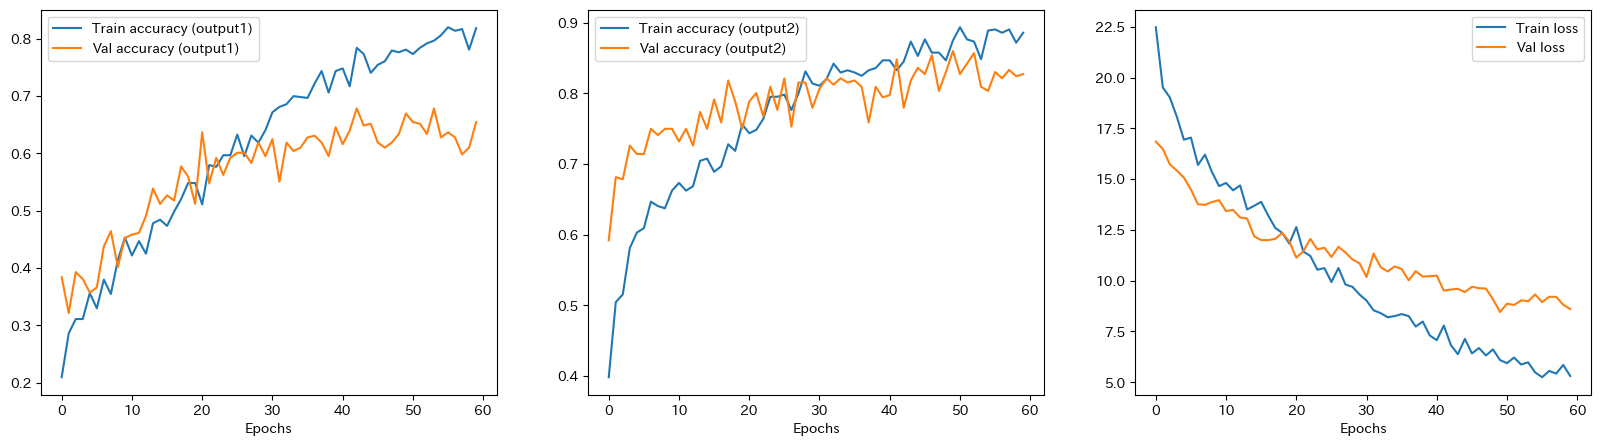

In [69]:
history_path = '{}/history.png'.format(output_dir)
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].plot(history.history['output1_accuracy'], label='Train accuracy (output1)')
    axes[0].plot(history.history['val_output1_accuracy'], label='Val accuracy (output1)')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['output2_accuracy'], label='Train accuracy (output2)')
    axes[1].plot(history.history['val_output2_accuracy'], label='Val accuracy (output2)')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['loss'], label='Train loss')
    axes[2].plot(history.history['val_loss'], label='Val loss')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()

    plt.savefig(history_path)

plot_train_history(history)

### テストデータセットで精度検証

In [21]:

output_dir = "weight-ones_output_20230308101851"

model_name = './{}/MIMO_model'.format(output_dir)
model.load_weights(model_name)


test_batch_size = 8 #len(test_idx)
print(test_batch_size)
test_gen = get_data_generator(df, test_idx, for_training=False, data_augmentation=False, batch_size=test_batch_size)


8


In [22]:
len(test_idx)/8

39.0

### テストデータ詳細確認用

In [23]:
x_test, y_test, predict = [],[],[]
predict_label_type  = []
predict_label_age  = []
y_test_print_type = []
y_test_print_age = []

for x in range(int(len(test_idx)/test_batch_size)):
    x_test_b, y_test_b = next(test_gen)
    predict_b = model.predict(x_test_b)

    predict_label_type.extend([np.argmax(predict_b[0], axis=1)])
    y_test_print_type.extend([np.argmax(y_test_b[0], axis=1)])

    predict_label_age.extend([np.argmax(predict_b[1], axis=1)])
    y_test_print_age.extend([np.argmax(y_test_b[1], axis=1)])
    
    x_test.extend([x_test_b])
    y_test.extend([y_test_b])
    predict.extend([predict_b])

1/1 [==============================] - 0s 217ms/step


In [24]:
print("{},{},{},{},{},{},{},{}".format('', '蓋・身', '列品番号', '回転角度', '正解ラベル-型式', '正解ラベル-時代', '推論ラベル-型式', '推論ラベル-時代'))

np.set_printoptions(formatter={'float': '{:.4e}'.format})
for y in range(len(y_test)):
    for x in range(len(y_test[y][0])):
        n = y*8 + x 
        i = test_idx[n]
        r = df.iloc[i]
        print("{},{},{},{:03}，{},{},{},{}".format(n, r['mifuta'], r['name'], r['angle'], \
                                                  num_to_class_type[r['label_type']], num_to_class_age[r['label_age']], \
                                                  num_to_class_type[predict_label_type[y][x]], num_to_class_age[predict_label_age[y][x]]))


,蓋・身,列品番号,回転角度,正解ラベル-型式,正解ラベル-時代,推論ラベル-型式,推論ラベル-時代
0,futa,J-13305-4,000，Ⅱ－３,中葉,Ⅱ－３,中葉
1,futa,J-13305-4,030，Ⅱ－３,中葉,Ⅱ－３,中葉
2,futa,J-13305-4,060，Ⅱ－３,中葉,Ⅱ－３,中葉
3,futa,J-13305-4,090，Ⅱ－３,中葉,Ⅱ－３,中葉
4,futa,J-13305-4,120，Ⅱ－３,中葉,Ⅱ－３,中葉
5,futa,J-13305-4,150，Ⅱ－３,中葉,Ⅱ－３,中葉
6,futa,J-13305-4,180，Ⅱ－３,中葉,Ⅱ－３,中葉
7,futa,J-13305-4,210，Ⅱ－３,中葉,Ⅱ－３,中葉
8,futa,J-13305-4,240，Ⅱ－３,中葉,Ⅱ－３,中葉
9,futa,J-13305-4,270，Ⅱ－３,中葉,Ⅱ－３,中葉
10,futa,J-13305-4,300，Ⅱ－３,中葉,Ⅱ－３,中葉
11,futa,J-13305-4,330，Ⅱ－３,中葉,Ⅱ－３,中葉
12,futa,J-134,000，Ⅱ－３,中葉,Ⅱ－３,中葉
13,futa,J-134,030，Ⅱ－３,中葉,Ⅱ－５,中葉
14,futa,J-134,060，Ⅱ－３,中葉,Ⅱ－５,前葉
15,futa,J-134,090，Ⅱ－３,中葉,Ⅱ－３,前葉
16,futa,J-134,120，Ⅱ－３,中葉,Ⅱ－５,前葉
17,futa,J-134,150，Ⅱ－３,中葉,Ⅱ－２,前葉
18,futa,J-134,180，Ⅱ－３,中葉,Ⅱ－３,中葉
19,futa,J-134,210，Ⅱ－３,中葉,Ⅱ－１,前葉
20,futa,J-134,240，Ⅱ－３,中葉,Ⅱ－３,中葉
21,futa,J-134,270，Ⅱ－３,中葉,Ⅱ－３,中葉
22,futa,J-134,300，Ⅱ－３,中葉,Ⅱ－５,前葉
23,futa,J-134,330，Ⅱ－３,中葉,Ⅱ－２,前葉
24,futa,J-20297,000，Ⅱ－１,前葉,Ⅱ－３,前葉
25,futa,J-20297,030，Ⅱ－１,前葉,Ⅱ－２,中葉
26,futa,J-20297,060，Ⅱ－１,前葉,Ⅱ－３,前葉
27,futa,J-20297,090，Ⅱ－１,前葉,Ⅱ－２,前葉
28,futa

<AxesSubplot: title={'center': '年代'}, xlabel='Predicted label', ylabel='True label'>

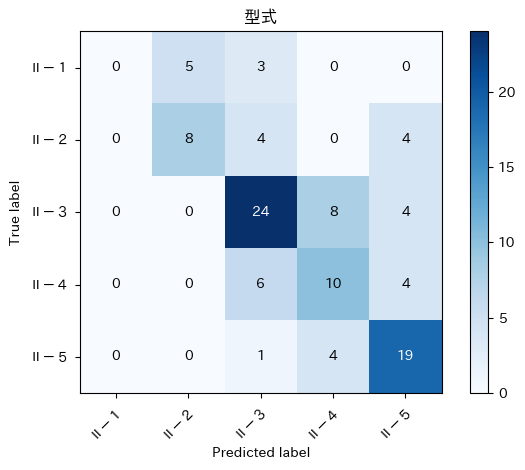

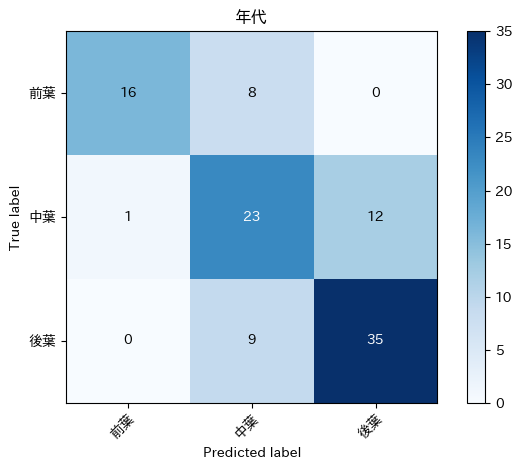

In [25]:
# 混同行列で見てみる
from sklearn.metrics import confusion_matrix

# おまけ
# 混同行列をもっと見やすく (参考: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title, classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor"
    )
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    confusion_matrix_path = '{}/confusion_matrix_{}'.format(output_dir, title)
    plt.savefig(confusion_matrix_path)
    return ax

plot_confusion_matrix(np.array(y_test_print_type).flatten()[::3], \
                      np.array(predict_label_type).flatten()[::3], \
                      '型式' ,classes=num_to_class_type.values())
plot_confusion_matrix(np.array(y_test_print_age).flatten()[::3], \
                      np.array(predict_label_age).flatten()[::3], \
                      '年代' ,classes=num_to_class_age.values())


In [26]:
from sklearn.metrics import classification_report

cr_type = classification_report(np.array(y_test_print_type).flatten()[::3], 
                                np.array(predict_label_type).flatten()[::3], 
                                target_names=num_to_class_type.values(), output_dict=True)
df_type = pd.DataFrame(cr_type)
df_type.transpose() # Ⅱ-1 ゼロ割警告が発生する

/home/nagumo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nagumo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nagumo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Ⅱ－１,0.000000,0.000000,0.000000,8.000000
Ⅱ－２,0.615385,0.500000,0.551724,16.000000
Ⅱ－３,0.631579,0.666667,0.648649,36.000000
Ⅱ－４,0.454545,0.500000,0.476190,20.000000
Ⅱ－５,0.612903,0.791667,0.690909,24.000000
accuracy,0.586538,0.586538,0.586538,0.586538
macro avg,0.462882,0.491667,0.473494,104.000000
weighted avg,0.542150,0.586538,0.560429,104.000000


In [27]:
from sklearn.metrics import classification_report

cr_age = classification_report(np.array(y_test_print_age).flatten()[::3], \
                               np.array(predict_label_age).flatten()[::3], \
                               target_names=num_to_class_age.values(), output_dict=True)
df_age = pd.DataFrame(cr_age)
df_age.transpose()

,precision,recall,f1-score,support
前葉,0.941176,0.666667,0.780488,24.000000
中葉,0.575000,0.638889,0.605263,36.000000
後葉,0.744681,0.795455,0.769231,44.000000
accuracy,0.711538,0.711538,0.711538,0.711538
macro avg,0.753619,0.700337,0.718327,104.000000
weighted avg,0.731290,0.711538,0.715071,104.000000


In [28]:
df.to_csv('./{}/dataset_2.csv'.format(output_dir))

In [29]:
df.head()

,mifuta,name,label_type,label_age,voxel_size,angle,voxel_path,image_top_path,image_side_path,image_bottom_path,dataset
0,futa,J-11536,4,2,128,0,./data_sueki/voxel_128/futa_J-11536_4_2_128_00...,./data_sueki/image/futa_J-11536_4_2_top_000.png,./data_sueki/image/futa_J-11536_4_2_side_000.png,./data_sueki/image/futa_J-11536_4_2_bottom_000...,train
1,futa,J-11536,4,2,128,30,./data_sueki/voxel_128/futa_J-11536_4_2_128_03...,./data_sueki/image/futa_J-11536_4_2_top_030.png,./data_sueki/image/futa_J-11536_4_2_side_030.png,./data_sueki/image/futa_J-11536_4_2_bottom_030...,train
2,futa,J-11536,4,2,128,60,./data_sueki/voxel_128/futa_J-11536_4_2_128_06...,./data_sueki/image/futa_J-11536_4_2_top_060.png,./data_sueki/image/futa_J-11536_4_2_side_060.png,./data_sueki/image/futa_J-11536_4_2_bottom_060...,train
3,futa,J-11536,4,2,128,90,./data_sueki/voxel_128/futa_J-11536_4_2_128_09...,./data_sueki/image/futa_J-11536_4_2_top_090.png,./data_sueki/image/futa_J-11536_4_2_side_090.png,./data_sueki/image/futa_J-11536_4_2_bottom_090...,train
4,futa,J-11536,4,2,128,120,./data_sueki/voxel_128/futa_J-11536_4_2_128_12...,./data_sueki/image/futa_J-11536_4_2_top_120.png,./data_sueki/image/futa_J-11536_4_2_side_120.png,./data_sueki/image/futa_J-11536_4_2_bottom_120...,train
